# scikit-ExSTraCS Complete User Guide

Author: Alexa Woodward, PhD, MS
Adapted from the original user guide by: Robert Zhang - University of Pennsylvania, B.S.E Computer Science, B.S.E. Economics (SEAS '22, WH '22)

Advisor: Ryan Urbanowicz, PhD - University of Pennsylvania, Department of Biostatics, Epidemiology, and Informatics & Institue for Biomedical Informatics (IBI)

## Introduction

This notebook presents a complete user guide to the core sklearn-compatible survival-ExSTraCS package as well as auxilliary helper objects included in the package. ExSTraCS 2.0 is a supervised learning variant of the Learning Classifier System. In general, Learning Classifier Systems (LCSs) are a classification of Rule Based Machine Learning Algorithms that have been shown to perform well on problems involving high amounts of heterogeneity and epistasis. Well designed LCSs are also highly human interpretable. LCS variants have been shown to adeptly handle supervised and reinforced, classification and regression, online and offline learning problems, as well as missing or unbalanced data. These characteristics of versatility and interpretability give LCSs a wide range of potential applications, notably those in biomedicine. This package is still under active development and we encourage you to check back on this repository for updates.

ExSTraCS 2.0, or Extended Supervised Tracking and Classifying System, implements the core components of a Michigan-Style Learning Classifier System (where the system's genetic algorithm operates on a rule level, evolving a population of rules with each their own parameters) in an easy to understand way, while still being highly functional in solving ML problems. It allows the incorporation of expert knowledge in the form of attribute weights, attribute tracking, rule compaction, and a rule specificity limit, that makes it particularly adept at solving highly complex problems.

While Learning Classifier Systems are commonly applied to genetic analyses, where epistatis (i.e. feature interactions) is common, the ExSTraCS algorithm implemented in this package can be applied to almost any supervised classification data set and supports:

<ul>
    <li>Feature sets that are discrete/categorical, continuous-valued or a mix of both</li>
    <li>Data with missing values</li>
    <li>Binary Classification Problems (Binary Endpoints)</li>
    <li>Multi-class Classification Problems (Multi-class Endpoints)</li>
    <li>Time-to-event/Survival Analysis</li>
</ul>



## Notebook Organization

**Part 1: Loading Data**
<ul>
    <li> Dataset format requirements for survival-ExSTraCS</li>
    <li> Method 1: Loading data using pandas</li>
    <li> Method 2: Loading data using StringEnumerator (additional data loading/transformation tool provided by ExSTraCS package)</li>
</ul>

**Part 2: Initializing survival-ExSTraCS Estimator Object**
<ul>
    <li> Basic Initialization</li>
    <li> Overview of all survival-ExSTraCS initialization parameters and default values</li>
</ul>

**Part 3: Model Training and Testing**
<ul>
    <li> model.fit(X,y)</li>
    <li> model.predict(X), model.predict_proba(X)</li>
    <li> model Cross Validation and Scoring</li>
    <li> C-statistic, Brier Scores and Integrated Brier Scores + Plots</li>
    <li> Auxilliary survival-ExSTraCS methods
</ul>

**Part 4: Data Collection and Export**
<ul>
    <li> trackingAccuracyWhileFit and other tracking metrics</li>
    <li> Exporting and Accessing Iteration Tracking Data </li>
    <li> Exporting and Accessing Rule Population Data </li>
</ul>

**Part 5: Population Reboot**

**Part 6: Post Training Rule Compaction**

## Loading required packages

In [1]:
import os
import pandas as pd
import numpy as np
import random
import sklearn
import matplotlib.pyplot as plt
import pickle
import math
import sys
import copy
import subprocess
from datetime import date
import time
import sksurv
import subprocess
from sklearn.model_selection import train_test_split
from eli5.sklearn import PermutationImportance
from sksurv.ensemble import RandomSurvivalForest
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

## Load scripts to run interactively

In [2]:
%run -i survival_AttributeTracking.py
%run -i survival_Classifier.py
%run -i survival_ClassifierSet.py
%run -i survival_DataManagement.py
%run -i survival_ExpertKnowledge.py
%run -i survival_ExSTraCS.py
%run -i survival_IterationRecord.py
%run -i survival_Pareto.py
%run -i survival_Prediction.py
%run -i survival_StringEnumerator.py
%run -i survival_OfflineEnvironment.py
%run -i survival_Timer.py
%run -i survival_RuleCompaction.py
%run -i survival_Metrics.py
%run -i utils.py
%run -i nonparametric_estimators.py

### Setting up test directories 

In [3]:
import os
import shutil

test_path = 'test/defaultExportDir'
if not os.path.exists(test_path):
    os.makedirs(test_path)
else:
    shutil.rmtree(test_path)
    os.makedirs(test_path)

### Setting up parameters and dataframes for scoring and evaluation

In [4]:
predList = None #list of predicted times 
predProbs = None #np array of predicted probabilities (over time)
attSums = None #attribute sums
featImp = None #feature importances
ibs_avg = None #average integrate brier scores

T = 100 #maximum time
ibs_df = pd.DataFrame() #empty dataframe for brier scores over time
ibs_df['times'] = range(T + 1)
ibs_df.set_index('times',inplace=True)

## Part 1: Loading Data

### Dataset Format Requirement for survival-ExSTraCS

There are 4 requirements for the dataset:
<ul>
    <li>Data Attributes for all data instances are represented by an <b>nxm</b> numpy.ndarray, where <b>n</b> = # of instances and <b>m</b> = # of attributes for each instance</li>
    <li>Data Events (time, censoring) for all data instances are represented by a 2 dimensional numpy.ndarray of length <b>n</b></li>
    <li>Both the <b>nxm</b> attribute array and the length <b>n</b> event array are fully numeric. This means that every element in each array must be convertable to a float. String, boolean types are not permitted (of course, boolean datasets can be represented by binary 0s and 1s). It is important to mention that missing data in the attribute dataset is acceptable, if represented as a NaN type within the array. Missing data in the events array is not acceptable.</li>
</ul>

The package includes automated parameter checking that will raise an Exception at the start of training if the dataset does not meet the above requirements.

Below, we present 2 methods to load data of the correct format for the ExSTraCS model. The first is the commonly used pandas. The second is a custom, standalone method included with this package named StringEnumerator, that will make your life much easier in terms of ensuring data formatting requirements are met for the ExSTraCS model.

### Loading Data Method 1: Using pandas

There are many ways you can derive the attribute and events array. One most common method is by using pandas via reading from a csv file, as the below code demonstrates with an example dataset:

In [5]:
#load data
data = pd.read_csv('test/main_effect_cens0.1_surv_2022-07-26_CV_0_Train.txt', sep = '\t', header = 0)
timeLabel = 'eventTime'
censorLabel = 'eventStatus'
inst = 'inst'

#Derive the attribute and event array using the phenotype label
dataFeatures = data.drop([inst,timeLabel,censorLabel],axis = 1).values
dataEvents = data[[timeLabel,censorLabel]].values


#Optional: Retrieve the headers for each attribute as a length n array
dataHeaders = data.drop([timeLabel,censorLabel],axis=1).columns.values

print("Data Features")
print(dataFeatures)
print("\nData Events")
print(dataEvents)
print("\nData Headers")
print(dataHeaders)

Data Features
[[0 0 0 ... 2 2 0]
 [1 1 1 ... 0 2 0]
 [1 1 0 ... 1 1 2]
 ...
 [0 0 1 ... 2 2 2]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]

Data Events
[[ 1  0]
 [ 1  1]
 [56  0]
 ...
 [56  1]
 [ 1  1]
 [ 1  1]]

Data Headers
['N0' 'N1' 'N2' 'N3' 'N4' 'N5' 'N6' 'N7' 'N8' 'N9' 'N10' 'N11' 'N12' 'N13'
 'N14' 'N15' 'N16' 'N17' 'N18' 'N19' 'N20' 'N21' 'N22' 'N23' 'N24' 'N25'
 'N26' 'N27' 'N28' 'N29' 'N30' 'N31' 'N32' 'N33' 'N34' 'N35' 'N36' 'N37'
 'N38' 'N39' 'N40' 'N41' 'N42' 'N43' 'N44' 'N45' 'N46' 'N47' 'N48' 'N49'
 'N50' 'N51' 'N52' 'N53' 'N54' 'N55' 'N56' 'N57' 'N58' 'N59' 'N60' 'N61'
 'N62' 'N63' 'N64' 'N65' 'N66' 'N67' 'N68' 'N69' 'N70' 'N71' 'N72' 'N73'
 'N74' 'N75' 'N76' 'N77' 'N78' 'N79' 'N80' 'N81' 'N82' 'N83' 'N84' 'N85'
 'N86' 'N87' 'N88' 'N89' 'N90' 'N91' 'N92' 'N93' 'N94' 'N95' 'N96' 'N97'
 'N98' 'M0P1' 'inst']


Great, now let's load example training and test files - if we want to run a full cross-validation, we can use the script "sim_full_pipeline_sLCS.py"

In [6]:
#Training data
data_train = pd.read_csv('test/main_effect_cens0.1_surv_2022-07-26_CV_0_Train.txt', sep = '\t', header = 0)
timeLabel = 'eventTime'
censorLabel = 'eventStatus'
instID = 'inst'

#Derive the attribute and phenotype array using the phenotype label
dataFeatures_train = data_train.drop([timeLabel,censorLabel,instID],axis = 1).values
dataEvents_train = data_train[[timeLabel,censorLabel]].values

#Optional: Retrieve the headers for each attribute as a length n array
dataHeaders_train = data_train.drop([timeLabel,censorLabel,instID],axis=1).columns.values

#split dataEvents into two separate arrays (time and censoring)
dataEventTimes_train = dataEvents_train[:,0]
dataEventStatus_train = dataEvents_train[:,1]

#Test data
data_test = pd.read_csv('test/main_effect_cens0.1_surv_2022-07-26_CV_0_Test.txt', sep = '\t', header = 0)
                
#Derive the attribute and phenotype array using the phenotype label
dataFeatures_test = data_test.drop([timeLabel,censorLabel,instID],axis = 1).values
dataEvents_test = data_test[[timeLabel,censorLabel]].values

#Optional: Retrieve the headers for each attribute as a length n array
dataHeaders_test = data_test.drop([timeLabel,censorLabel,instID],axis=1).columns.values

#split dataEvents into two separate arrays (time and censoring)
dataEventTimes_test = dataEvents_test[:,0]
dataEventStatus_test = dataEvents_test[:,1]

### Loading Data Method 2: Using StringEnumerator

Given the 4 requirements for the attribute and phenotype array, not all datasets necessarily satisfy those requirements. For example, a dataset may contain an attribute with values that are colors "red", "green", "blue". Since the scikit-ExSTraCS model can only work with numeric data, this dataset would not meet the requirements. Alternatively, a dataset may, for some reason, have missing phenotype data. Since the scikit-ExSTraCS model requires that the phenotype array is complete, this dataset would also not meet the requirements.

To make things more convenient, included in this package is an auxilliary data type called **String Enumerator** that makes it easy to transform datasets that do not meet the requirements into datasets that do.

For example, take the below dummy dataset:

'''
import pandas as pd

#Read from CSV file
data = pd.read_csv("test/DataSets/Tests/StringData2.csv")

#Specify the dataset's phenotype label
classLabel = "phenotype"

#Derive the attribute and phenotype array using the phenotype label
dataFeatures = data.drop(classLabel,axis = 1).values
dataPhenotypes = data[classLabel].values

#Optional: Retrieve the headers for each attribute as a length n array
dataHeaders = data.drop(classLabel,axis=1).columns.values

print("Data Features")
print(dataFeatures)
print("\nData Phenotypes")
print(dataPhenotypes)
print("\nData Headers")
print(dataHeaders)
'''

This dummy dataset does not come close to meeting the dataset requirements for training. There exist many string types in the attribute and phenotype array, as well as missing phenotype data. Aside from not meeting the requirements, the data headers and phenotype label are not too descriptive. Below StringEnumerator cleans this up.

## Part 2: Initializing scikit-ExSTraCS Estimator Object

### Basic Initialization

In [7]:
from survival_ExSTraCS import ExSTraCS
model  = ExSTraCS()

Doing the above will initialize an ExSTraCS estimator object using the default hyperparameters, that is now ready for training. However, in most cases, you would want to modify some hyperparameters to your needs. We list all of the tunable hyperparameters and their descriptions:

### Overview of all scikit-ExSTraCS initialization parameters and default values

| Parameter Name | Requirements | Description | Default Value |
| :--- | :--- | :--- | :--- |
| learning_iterations | non negative integer | The number of training cycles to run | 100000 |
| N | non negative integer | Maximum microclassifier population size (sum of classifier numerosities) | 1000 |
| nu (v) | float | Power parameter used to determine the importance of high accuracy when calculating fitness | 1 |
| chi (X) | float from 0 - 1 | The probability of applying crossover in the GA | 0.8 |
| mu (u) | float from 0 - 1 | The probability of mutating an allele within an offspring | 0.04 |
| theta_GA | non negative float | The GA threshold. The GA is applied in the correct set when the average time (# of iterations) since the last GA in the correct set is greater than theta_GA | 25 |
| theta_del | non negative integer | The deletion experience threshold; The calculation of the deletion probability changes once this threshold is passed | 20 |
| theta_sub | non negative integer | The subsumption experience threshold | 20 |
| acc_sub | float from 0 - 1 | Subsumption accuracy requirement | 0.99 |
| beta | float | Learning parameter; Used in calculating average correct set size | 0.2 |
| delta | float | Deletion parameter; Used in determining deletion vote calculation | 0.1 |
| init_fitness | float | The initial fitness for a new classifier (typically very small, approaching but not equal to zero) | 0.01 |
| fitness_reduction | float | Initial fitness reduction in GA offspring rules | 0.1 |
| theta_sel | float from 0 - 1 | The fraction of the correct set to be included in tournament selection | 0.5 |
| rule_specificity_limit | non negative integer or None | If not None, overrides the automatically computed RSL. Else use automatically computed RSL | None |
| do_correct_set_subsumption | boolean | Determines if subsumption is done in correct set| False |
| do_GA_subsumption | boolean | Determines if subsumption is done after GA between parents and offspring classifiers| True |
| selection_method | "tournament" or "roulette" | Determines GA selection method | "tournament" |
| do_attribute_tracking | boolean | Determines if AT occurs during training | True |
| do_attribute_feedback | boolean | Determines if AF occurs during training | True |
| attribute_tracking_method | "add" or "wh" | Determine AT score update method (Addition or Widrow Hoff) | "add" |
| attribute_tracking_beta | float | learning rate used for widrow hoff AT score update. | 0.1 |
| expert_knowledge | numpy.ndarray or list or None of length # attributes | Uses list of attribute weights as a basis for expert knowledge. If None, no EK is used | None |
| rule_compaction | 'QRF' or 'PDRC' or 'QRC' or 'CRA2' or 'Fu1' or 'Fu2' of None| Select RC method, or None | 'QRF' |


Below, for your reference, we also put together a table that shows how the training process may be effected, if one of the above attributes were changed:

| Parameter Name | Impact on training when changed |
| :--- | :--- |
| learning_iterations | more iterations increases accuracy (up to a point - there exists diminishing returns), but also increases training time |
| N | for larger feature spaces, a larger N is recommended. A larger N increases training time, but too small of an N will prevent the LCS from converging on a solution |
| nu (v) | recommended to be 1 for data with any level of noise. Increasing nu in clean problems improves chances of converging on optimal solution. Default of 5 is common for clean problems |
| chi (X) | recommended to use default parameter |
| mu (u) | recommended to use default parameter |
| theta_GA | recommended to use default parameter |
| theta_del | recommended to use default parameter |
| theta_sub | recommended to use default parameter |
| acc_sub | for clean problems, recommended this is very close to or equal to 1 |
| beta | recommended to use default parameter |
| delta | recommended to use default parameter |
| init_fitness | recommended to use default parameter |
| fitness_reduction | recommended to use default parameter |
| theta_sel | recommended to use default parameter |
| rule_specificity_limit | recommended to use default parameter |
| do_correct_set_subsumption | recommended to use default parameter |
| do_GA_subsumption | recommended to use default parameter |
| selection_method | tournament selection has been found to yield higher performance |
| do_attribute_tracking | recommended to use default parameter |
| do_attribute_feedback | recommended to use default parameter |
| attribute_tracking_method | 'wh' has been shown to improve rule population interpretability |
| attribute_tracking_beta | recommended to use default parameter |
| expert_knowledge | recommended to load in a list of generated expert knowledge scores |
| rule_compaction | each rule compaction method has its benefits, depending on the problem |


There also exists a few hyperparameters related to the setup and evaluation of the training process:

| Parameter Name | Requirements | Description | Default Value |
| :--- | :--- | :--- | :--- |
| track_accuracy_while_fit | boolean | Determines if live accuracy tracking is done during model training | False |
| discrete_attribute_limit | non negative integer OR "c" OR "d" | Multipurpose param. If it is a nonnegative integer, discrete_attribute_limit determines the threshold that determines if an attribute will be treated as a continuous or discrete attribute. For example, if discrete_attribute_limit == 10, if an attribute has more than 10 unique values in the dataset, the attribute will be continuous. If the attribute has 10 or less unique values, it will be discrete. Alternatively, discrete_attribute_limit can take the value of "c" or "d". See next param for this. | 10 |
| specified_attributes | numpy.ndarray of nonnegative integers of attribute indices | If discrete_attribute_limit == "c", attributes specified by index in this param will be continuous and the rest will be discrete. If "d", attributes specified by index in this param will be discrete and the rest will be continuous | empty numpy ndarray |
| random_state | integer or None | Set a constant random seed value to some integer (in order to obtain reproducible results). | None |
| reboot_filename | str or None | File name of pickled model to be rebooted. None by default (no model to reboot) | None |

These hyperparameters can be set during initialization. There exists built in parameter checking to ensure each specified parameter is valid. Below is an example:

In [8]:
model = ExSTraCS(learning_iterations = 10000)

## Part 3: Model Training and Testing

### model.fit(X, y)
Once the model is initialized with the hyperparameters you want, you can train the model by calling the fit(X,y) method, where X is the numpy.ndarray of attributes and y is the numpy.ndarray of phenotypes. Be sure both X and y satisfy the requirements specified in Part 1, or the parameter checker will raise an Exception. Below we demo the entire process of importing relevant packages, loading data, model initialization, and model training:

In [9]:
#Initialize and train model
model = ExSTraCS(learning_iterations = 10000,nu=10,N=1000,track_accuracy_while_fit=True)
trainedModel = model.fit(dataFeatures_train,dataEventTimes_train,dataEventStatus_train)
trainedModel

nothing stored on pareto front


ExSTraCS(learning_iterations=10000, nu=10, rule_specificity_limit=6)

Once the model has finished training, you can call the predict(X) method to return an numpy.ndarray of class predictions given an array of unlabelled instances. The predict method works by using the final rule population of the model to vote on the most probable class based on classifier fitness and numerosity. Before making a prediction, parameter checkers again ensure X is a valid input (fully numeric numpy.ndarray). We refer back to the trained model above.

In [10]:
trainedModel.predict(dataFeatures_test)

array([2.59165019, 2.59165019, 2.59165019, 2.69891176, 2.59165019,
       2.59165019, 2.9190796 , 2.59165019, 2.69891176, 2.59165019,
       2.59165019, 2.9190796 , 2.9190796 , 1.22110722, 1.32836879,
       2.69891176, 1.32836879, 2.59165019, 2.69891176, 2.69891176,
       1.22110722, 1.22110722, 2.59165019, 2.59165019, 2.69891176,
       1.22110722, 2.59165019, 2.59165019, 2.59165019, 1.22110722,
       2.59165019, 2.59165019, 2.59165019, 2.69891176, 2.59165019,
       2.59165019, 1.22110722, 1.22110722, 2.9190796 , 2.59165019,
       2.59165019, 2.59165019, 2.59165019, 2.59165019, 2.59165019,
       2.69891176, 1.22110722, 2.59165019, 2.59165019, 1.22110722,
       1.32836879, 2.59165019, 2.9190796 , 2.59165019, 2.9190796 ,
       1.22110722, 2.9190796 , 2.59165019, 2.59165019, 2.59165019,
       2.59165019, 1.22110722, 1.22110722, 2.59165019, 2.69891176,
       2.59165019, 2.59165019, 2.69891176, 2.59165019, 1.22110722,
       2.59165019, 2.59165019, 1.22110722, 2.69891176, 2.59165

You can also call the predict_proba(X) method to return an nxm numpy.ndarray of phenotype probabilities, where n = number of data instances and m = number of distinct discrete phenotypes.

### Cross Validation, Comparison Approaches, and Scoring
You can score a set of predictions using the score(X,y) method, where X is the unlabelled test data and y is associated list of correct class values. By default, score(X,y) uses balanced accuracy to score.

In [11]:
scoreEvents_train = np.flip(dataEvents_train, 1)
scoreEvents_test = np.flip(dataEvents_test, 1)

scoreEvents_train = np.core.records.fromarrays(scoreEvents_train.transpose(),names='cens, time', formats = '?, <f8')
scoreEvents_test = np.core.records.fromarrays(scoreEvents_test.transpose(),names='cens, time', formats = '?, <f8')


### Convert float data to int
dataEventTimes_train = dataEventTimes_train.astype('int64')
dataEventTimes_test = dataEventTimes_test.astype('int64')
dataEventStatus_train = dataEventStatus_train.astype('int64')
dataEventStatus_test = dataEventStatus_test.astype('int64')

In [12]:
#Create empty dataframes for comparison approaches
cox_df = pd.DataFrame()
rsf_df = pd.DataFrame()


if dataFeatures_train.shape[1] < 101:
    CoxPH = make_pipeline(CoxPHSurvivalAnalysis(alpha = 0.00001))
    CoxPH.fit(dataFeatures_train, scoreEvents_train)
    perm = PermutationImportance(CoxPH.steps[-1][1], n_iter=10, random_state=42).fit(dataFeatures_train,scoreEvents_train)

    cox_data = perm.results_
    cox_data = pd.DataFrame(cox_data, columns=dataHeaders_train) #remove index label

    #Random survival forest
    rsf = make_pipeline(RandomSurvivalForest(random_state=42))
    rsf.fit(dataFeatures_train,scoreEvents_train)

    perm_rsf = PermutationImportance(rsf.steps[-1][1], n_iter=10, random_state=42).fit(dataFeatures_train,scoreEvents_train)
    rsf_data = perm_rsf.results_
    rsf_data = pd.DataFrame(rsf_data, columns=dataHeaders_train)

    #concat dfs
    cox_df = pd.concat([cox_df, cox_data], ignore_index=True, axis=0)
    rsf_df = pd.concat([rsf_df, rsf_data], ignore_index=True, axis=0)
else:
    print("Comparison approaches not run on datasets with > 100 features")

Pipeline(steps=[('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=1e-05))])

Pipeline(steps=[('randomsurvivalforest',
                 RandomSurvivalForest(random_state=42))])

### Generating predicted times and probabilities for the test data

In [13]:
if predList is None:
    predList = trainedModel.predict(dataFeatures_test)
else:
    predList = np.append(predList, trainedModel.predict(dataFeatures_test))

#print(self.predList)

if predProbs is None:
    predProbs = pd.DataFrame(trainedModel.predict_proba(dataFeatures_test, dataEventTimes_test)).T
                    #print(predProbs.head())
else:
    predProbs = pd.concat([predProbs, pd.DataFrame(trainedModel.predict_proba(dataFeatures_test, dataEventTimes_test)).T])

### Retrieving the attribute sums for each attribute 

In [14]:
if attSums is None:
    attSums = np.array(trainedModel.AT.getSumGlobalAttTrack(trainedModel))
    featImp = attSums #this is going to be an nd.array used to make a box plot later
else:
    attSums = attSums + np.array(trainedModel.AT.getSumGlobalAttTrack(trainedModel))
    featImp = np.vstack((featImp, np.array(trainedModel.AT.getSumGlobalAttTrack(trainedModel))))
print("featImp: ", featImp)

featImp:  [ 23297.03793305  24601.91253622  17839.58459404  32771.58812381
  12995.13076748  35401.9773947   27917.26008181  10876.43093137
  53151.7968265   52045.35614732  19134.2549643   11331.10260476
  37537.96405386  30413.0894554   69054.87046691   9367.63785579
  34823.77868956 117147.02807908  15940.6278393   45832.64446466
   8557.59786318  25016.46904143  27037.15637591   5748.0487716
  29800.56581998  37525.22056595   9968.05514617  19112.89536148
  24309.29078573  15989.990859    12381.31774459  21304.36710785
  21589.07594653  11711.63753945 144045.39411534  20804.91956849
  11523.32021834  19184.47874003   6391.6095515   30574.940888
  10979.87046442   8766.06848228   3485.18418868  45309.2920353
  19461.12266252  18568.67825143  63760.48920013  12148.58063187
  29453.30014933  12855.70318554  30093.00365857  22460.33903718
  24113.26023479   4442.39242456  24332.75135081 127089.36874813
  15141.58305825   8083.72618228  62586.03645535  59225.71931224
  15550.85411633  1

### Generating integrated brier scores to assess accuracy of the model over all possible times 

In [15]:
times, b_scores = trainedModel.brier_score(dataFeatures_test,dataEventStatus_test,dataEventTimes_test,dataEventTimes_train,scoreEvents_train,scoreEvents_test)
tb=pd.DataFrame({'times':times, 'b_scores':b_scores})
tb.set_index('times',inplace=True)


#sum, then average scores
ibs_df = pd.concat([tb,ibs_df],axis=1,sort=False).reset_index()
ibs_df.set_index('times',inplace=True)

ibs_df.head()

len predProbs:  334 pred probs shape;  (334, 93)
len time points:  93 max time points:  93.0


,b_scores
times,
1.0,0.645699
2.0,0.447131
3.0,0.293819
4.0,0.222549
5.0,0.215915


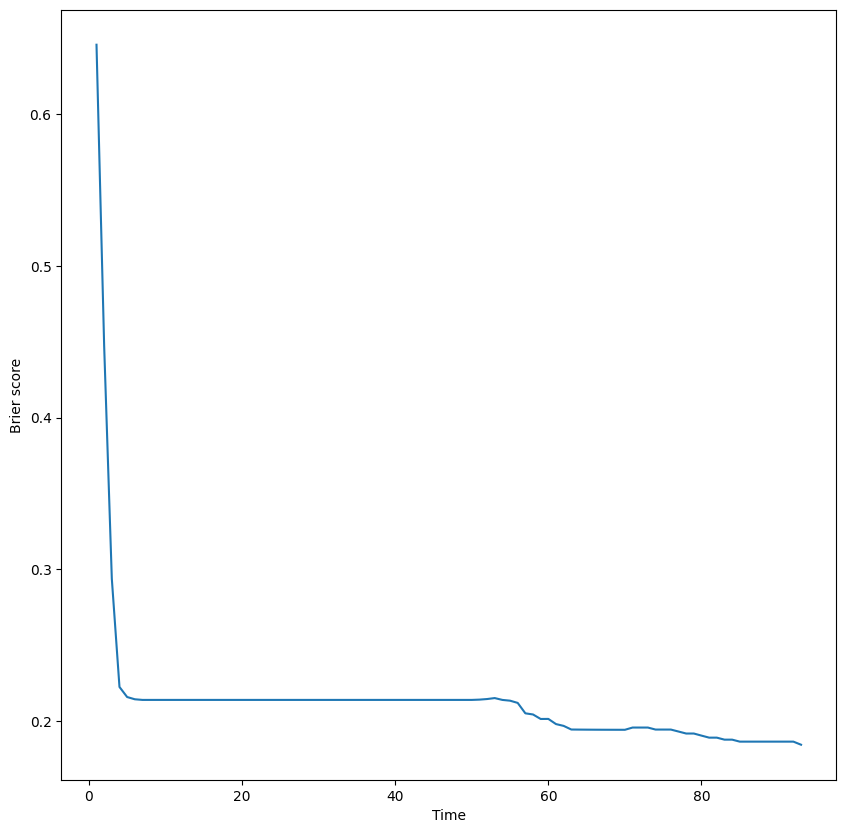

In [16]:
#Plot the IBS scores
trainedModel.plot_ibs(times, b_scores)

In [17]:
print(predList)

[2.59165019 2.59165019 2.59165019 2.69891176 2.59165019 2.59165019
 2.9190796  2.59165019 2.69891176 2.59165019 2.59165019 2.9190796
 2.9190796  1.22110722 1.32836879 2.69891176 1.32836879 2.59165019
 2.69891176 2.69891176 1.22110722 1.22110722 2.59165019 2.59165019
 2.69891176 1.22110722 2.59165019 2.59165019 2.59165019 1.22110722
 2.59165019 2.59165019 2.59165019 2.69891176 2.59165019 2.59165019
 1.22110722 1.22110722 2.9190796  2.59165019 2.59165019 2.59165019
 2.59165019 2.59165019 2.59165019 2.69891176 1.22110722 2.59165019
 2.59165019 1.22110722 1.32836879 2.59165019 2.9190796  2.59165019
 2.9190796  1.22110722 2.9190796  2.59165019 2.59165019 2.59165019
 2.59165019 1.22110722 1.22110722 2.59165019 2.69891176 2.59165019
 2.59165019 2.69891176 2.59165019 1.22110722 2.59165019 2.59165019
 1.22110722 2.69891176 2.59165019 2.9190796  2.9190796  2.59165019
 2.59165019 2.69891176 2.59165019 2.59165019 2.69891176 2.59165019
 2.59165019 2.59165019 2.69891176 2.69891176 2.59165019 2.91907

(array([ 80.,   0.,   0.,   0.,   0.,   0., 223.,  28.,   0.,   3.]),
 array([1.22110722, 1.43607944, 1.65105166, 1.86602388, 2.0809961 ,
        2.29596832, 2.51094054, 2.72591276, 2.94088498, 3.1558572 ,
        3.37082942]),
 <BarContainer object of 10 artists>)

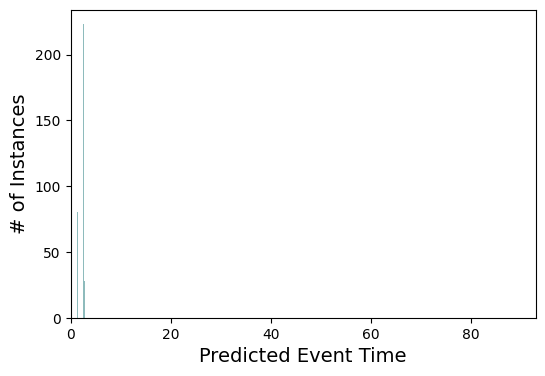

In [18]:
#Plot the predicted probabilties
trainedModel.plotPreds(predList) #plots the predicted times of the test data across all CVs

You can also use different scoring metrics to score the model. We will do this with a quick cross validation on the model. Below we will run a 3 fold CV on the trained model from above. Again, by default, balanced accuracy is used to score each partition.

If you prefer to use a scoring method other than balanced accuracy during CV (e.g. accuracy_score, precision_score, recall_score, f1_score), that can be specified as well via the standard scoring parameter. Be aware that some of these scoring methods only accept binary endpoints.

### Auxilliary scikit-ExSTraCS methods
In addition to the standard sklearn methods you can use to access training metrics, scikit-ExSTraCS provides a few of its own.

| Method Name | Description |
| :--- | :--- |
| model.get_final_training_accuracy() | Evaluates (in real time) the final training accuracy of the model |
| model.get_final_instance_coverage() | Evaluates (in real time) the final instance coverage of the model |
| model.get_final_attribute_specificity_list() | Returns a list of attribute specificities (which attributes are specified the most in the rule population) |
| model.get_final_attribute_accuracy_list() | Returns a list of attribute specificities weighted by accuracy |
| model.get_final_attribute_tracking_sums() | Returns a list of attribute tracking sums |
| model.get_final_attribute_coocurrences(headers,maxNumAttributesToTrack=50) | Returns a list of attribute cooccurences |
| model.get_attribute_tracking_scores(instanceLabels) | Returns a list of AT score for each instance. Instance labels must be in the order of the given training data.

In [19]:
# headers = dataHeaders[:-1]
# len(headers)

In [20]:
# print("Final Training Accuracy: "+str(trainedModel.get_final_training_accuracy()))
# print("Final Instance Coverage: "+str(trainedModel.get_final_instance_coverage()))
print("Final Attribute Specificity List: "+str(trainedModel.get_final_attribute_specificity_list()))
print("Final Attribute Accuracy List: "+str(trainedModel.get_final_attribute_accuracy_list()))
print("Final Attribute Tracking Sums:")
print(trainedModel.get_final_attribute_tracking_sums())
# print("Final Attribute Cooccurences:")
# print(trainedModel.get_final_attribute_coocurrences(headers))

instanceLabels = []
for i in range(dataFeatures.shape[0]):
    instanceLabels.append(i)
print(model.get_attribute_tracking_scores(np.array(instanceLabels)))

Final Attribute Specificity List: [16, 14, 13, 17, 9, 12, 14, 7, 29, 32, 24, 7, 23, 15, 24, 8, 19, 64, 15, 29, 6, 14, 13, 9, 20, 34, 11, 14, 12, 12, 8, 14, 12, 9, 76, 11, 8, 18, 10, 21, 7, 5, 4, 25, 15, 15, 30, 3, 17, 7, 18, 14, 14, 3, 11, 55, 17, 6, 30, 23, 12, 12, 4, 20, 10, 22, 8, 14, 42, 23, 7, 17, 9, 13, 10, 80, 11, 8, 6, 11, 25, 68, 3, 46, 11, 21, 4, 0, 5, 7, 9, 21, 22, 6, 8, 40, 25, 7, 15, 252]
Final Attribute Accuracy List: [15.539789444652596, 12.49481488948275, 12.618357623010088, 16.42703896179967, 8.61979461000222, 11.165104124313748, 13.652069465999032, 6.745890189805721, 27.744367375379227, 31.226137161611394, 22.343262744818706, 6.789305303073096, 22.05538402158411, 14.527614179053575, 23.047666540804272, 7.794869024367685, 18.503646801012625, 62.5413450898375, 14.441943131246228, 27.192469654315854, 5.807077608909694, 13.607442026399205, 12.614127986411217, 7.864344929209743, 19.38875376676804, 33.066820666840925, 10.695833080265428, 13.555825072528059, 11.6775250208273

## Part 4: Data Collection and Export

### track_accuracy_while_fit and other tracking metrics
As mentioned in Part 2, there exists the parameter **track_accuracy_while_fit** that determines whether the approximate accuracy of the model is computed during training or not. The benefit to doing this during training is that you will be able to collect data on how accuracy of the model changes over many iterations. The downside to tracking approximate accuracy during training is that evaluation always slows down the training process (but by a relatively small amount). Approximate accuracy is computed via a 50 iteration moving average of prediction accuracies. At each iteration, if **track_accuracy_while_fit** is true, ExSTraCS will make a prediction of the current instance's class. The correctness of this prediction is factored into the moving average. It's important to note that tracked accuracy is a standard accuracy, rather than a balanced accuracy.

In addition to tracking approximate accuracy, scikit-ExSTraCS also tracks a series of other training statistics that may be of use. Aside from average rule population generality (which is tracked at least once an epoch), these following statistics are tracked every iteration:
<ul>
    <li>Average rule population generality (average percentage of rule that is generalized)</li>
    <li>Macropopulation size</li>
    <li>Micropopulation size</li>
    <li>Match set size</li>
    <li>Correct set size</li>
    <li>Average iteration age of classifiers in correct set</li>
    <li>Number of classifiers subsumed in iteration</li>
    <li>Number of crossover operations performed in iteration (GA operation)</li>
    <li>Number of mutation operations performed in iteration (GA operation)</li>
    <li>Number of covering operations performed in iteration</li>
    <li>Number of macroclassifiers deleted in iteration</li>
    <li>Number of macroclassifiers deleted in rule compaction</li>
    <li>Total training time</li>
    <li>Total matching time</li>
    <li>Total covering time</li>
    <li>Total crossover time</li>
    <li>Total mutation time</li>
    <li>Total attribute tracking time</li>
    <li>Total expert knowledge processing time</li>
    <li>Total initialization time</li>
    <li>Total classifier addition time</li>
    <li>Total rule compaction time</li>
    <li>Total deletion time</li>
    <li>Total subsumption time</li>
    <li>Total selection time</li>
    <li>Total evaluation time</li>
</ul>

These statistics are not time intensive to compute, and thus can be tracked every iteration. 

Why is collecting this kind of iteration by iteration data important? Unlike many other machine learning models, as the ExSTraCS trains, it is easy to visualize its training process, such as how its accuracy or its macropopulation size changes over time. Thus, doing iteration tracking will allow you to export this training progess data (as you will see below) to aid in this visualization. Also, LCSs are stochastic algorithms with no clear stop criteria, so tracking these metrics will allow you to identify when training has stagnated, which can help in future hyperparameter optimization.

### Exporting and Accessing Iteration Tracking Data
To access this iteration tracking data, you can call the following method that exports the entire tracking data record from training into a local folder:

| Method Name | Description |
| :--- | :--- |
| model.export_iteration_tracking_data(filename) | Exports all tracked data from training |

The filename paramater is optional. By default, the program saves a CSV file named **iterationData.csv** into your local directory. However, you can set the filename param as an absolute path with the format **/filepath/filename.csv** which will save the data into any specified directory.

In [21]:
trainedModel.export_iteration_tracking_data("test/defaultExportDir/iterationData.csv")

The exported CSV is below:

In [22]:
iterationData = pd.read_csv("test/defaultExportDir/iterationData.csv")
display(iterationData)

,Iteration,Accuracy (approx),Average Population Generality,Macropopulation Size,Micropopulation Size,Match Set Size,Correct Set Size,Average Iteration Age of Correct Set Classifiers,# Classifiers Subsumed in Iteration,# Crossover Operations Performed in Iteration,...,Total Mutation Time,Total Attribute Tracking Time,Total Expert Knowledge Time,Total Model Initialization Time,Total Classifier Add Time,Total Rule Compaction Time,Total Deletion Time,Total Subsumption Time,Total Selection Time,Total Evaluation Time
0,0,0.913978,0.00000,1,1,1,1,0.000000,0,0,...,0.000000,0.000563,0.0,0.132061,0.001520,0.000000,0.000001,0.000000,0.000000,0.000024
1,1,0.934677,0.00000,2,2,1,1,1.000000,0,0,...,0.000000,0.000643,0.0,0.132061,0.002289,0.000000,0.000002,0.000000,0.000000,0.000046
2,2,0.956452,0.00000,3,3,1,1,2.000000,0,0,...,0.000000,0.000714,0.0,0.132061,0.002906,0.000000,0.000003,0.000000,0.000000,0.000061
3,3,0.952120,0.00000,4,4,2,1,3.000000,0,0,...,0.000000,0.000793,0.0,0.132061,0.003498,0.000000,0.000004,0.000000,0.000000,0.000080
4,4,0.948272,0.00000,5,5,2,1,4.000000,0,0,...,0.000000,0.000862,0.0,0.132061,0.004166,0.000000,0.000004,0.000000,0.000000,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,0.888885,0.97904,825,1000,248,244,4707.833887,0,0,...,0.067693,2.126698,0.0,0.132061,3.163823,0.000000,1.686877,3.129393,0.167163,16.805182
9997,9997,0.888590,0.97904,825,1000,318,318,4730.971722,0,0,...,0.067693,2.126979,0.0,0.132061,3.163823,0.000000,1.686877,3.129393,0.167163,16.807835
9998,9998,0.888524,0.97904,825,1000,334,328,4757.254499,0,0,...,0.067693,2.127272,0.0,0.132061,3.163823,0.000000,1.686878,3.129393,0.167163,16.810719
9999,9999,0.888524,0.97904,825,1000,290,286,4641.188732,0,0,...,0.067693,2.127538,0.0,0.132061,3.163823,0.000000,1.686879,3.129393,0.167163,16.813055


Once the data is exported to a CSV, you can plot trendlines for each statistic. We will use pandas and matplotlib as a demo below. Please note that for the average accuracy and average generality graphs, the first number of iterations is not as "accurate" as the rest of the iterations. The average accuracy moving average only begins moving at iteration 50, and average generality is not tracked until a few hundred iterations in.

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'accuracy/generality')

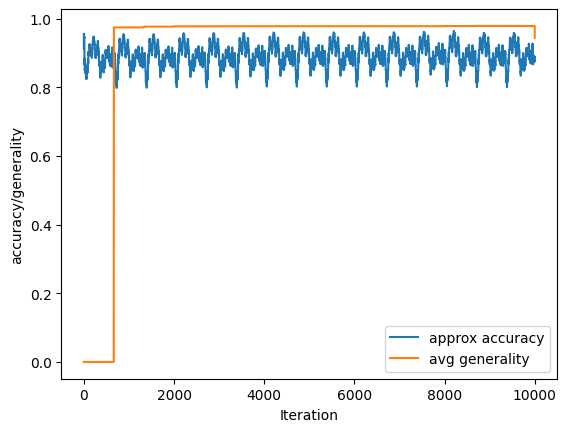

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Macro/MicroPop Size')

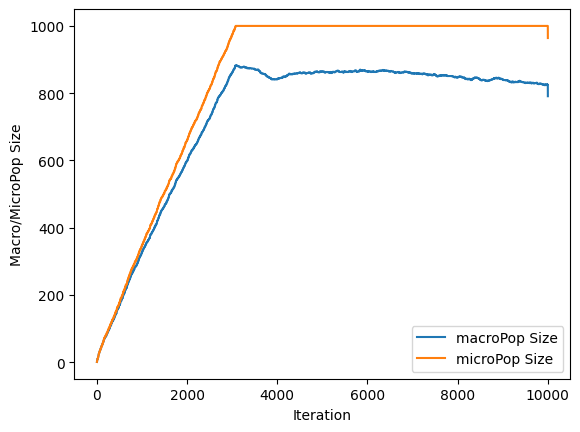

Text(0.5, 0, 'Iteration')

Text(0, 0.5, '[M]/[C] size per iteration')

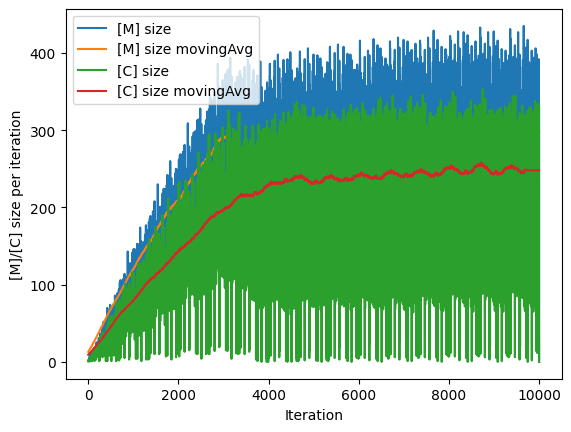

Text(0, 0.5, 'Average [C] Classifier Age')

Text(0.5, 0, 'Iteration')

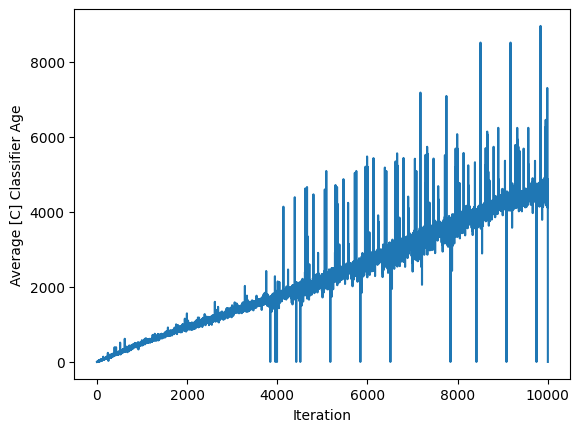

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Cumulative Operations Count Over Iterations')

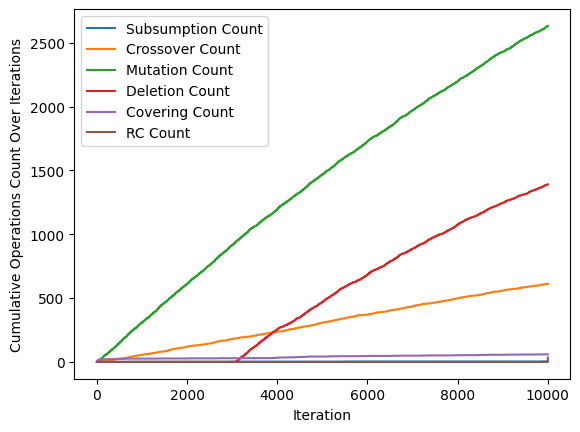

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Cumulative Time (Stacked)')

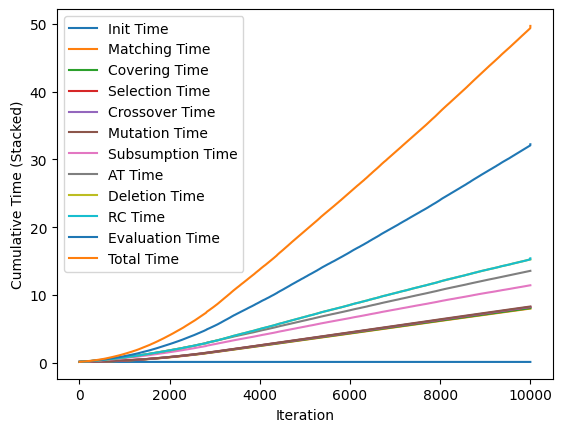

In [23]:
import matplotlib.pyplot as plt

def cumulativeFreq(freq):
    a = []
    c = []
    for i in freq:
        a.append(i+sum(c))
        c.append(i)
    return np.array(a)

def movingAvg(a,threshold=300):
    weights = np.repeat(1.0,threshold)/threshold
    conv = np.convolve(a,weights,'valid')
    return np.append(conv,np.full(threshold-1,conv[conv.size-1]),)

dataTracking = pd.read_csv("test/defaultExportDir/iterationData.csv")

iterations = dataTracking["Iteration"].values
accuracy = dataTracking['Accuracy (approx)'].values
generality = dataTracking['Average Population Generality'].values
macroPop = dataTracking["Macropopulation Size"].values
microPop = dataTracking["Micropopulation Size"].values
mSize = dataTracking["Match Set Size"].values
cSize = dataTracking["Correct Set Size"].values
experience = dataTracking["Average Iteration Age of Correct Set Classifiers"].values
subsumption = dataTracking["# Classifiers Subsumed in Iteration"].values
crossover = dataTracking["# Crossover Operations Performed in Iteration"].values
mutation = dataTracking["# Mutation Operations Performed in Iteration"].values
covering = dataTracking["# Covering Operations Performed in Iteration"].values
deletion = dataTracking["# Deletion Operations Performed in Iteration"].values
rc = dataTracking["# Rules Removed via Rule Compaction"].values

gTime = dataTracking["Total Global Time"].values
mTime = dataTracking["Total Matching Time"].values
covTime = dataTracking["Total Covering Time"].values
crossTime = dataTracking["Total Crossover Time"].values
covTime = dataTracking["Total Covering Time"].values
mutTime = dataTracking["Total Mutation Time"].values
atTime = dataTracking["Total Attribute Tracking Time"].values
initTime = dataTracking["Total Model Initialization Time"].values
rcTime = dataTracking["Total Rule Compaction Time"].values
delTime = dataTracking["Total Deletion Time"].values
subTime = dataTracking["Total Subsumption Time"].values
selTime = dataTracking["Total Selection Time"].values
evalTime = dataTracking["Total Evaluation Time"].values

plt.plot(iterations,accuracy,label="approx accuracy")
plt.plot(iterations,generality,label="avg generality")
plt.xlabel('Iteration')
plt.ylabel('accuracy/generality')
plt.legend()
plt.show()

plt.plot(iterations,macroPop,label="macroPop Size")
plt.plot(iterations,microPop,label="microPop Size")
plt.xlabel('Iteration')
plt.ylabel('Macro/MicroPop Size')
plt.legend()
plt.show()

plt.plot(iterations,mSize,label="[M] size")
plt.plot(iterations,movingAvg(mSize),label="[M] size movingAvg")
plt.plot(iterations,cSize,label="[C] size")
plt.plot(iterations,movingAvg(cSize),label="[C] size movingAvg")
plt.xlabel('Iteration')
plt.ylabel('[M]/[C] size per iteration')
plt.legend()
plt.show()

plt.plot(iterations,experience)
plt.ylabel('Average [C] Classifier Age')
plt.xlabel('Iteration')
plt.show()

plt.plot(iterations,cumulativeFreq(subsumption),label="Subsumption Count")
plt.plot(iterations,cumulativeFreq(crossover),label="Crossover Count")
plt.plot(iterations,cumulativeFreq(mutation),label="Mutation Count")
plt.plot(iterations,cumulativeFreq(deletion),label="Deletion Count")
plt.plot(iterations,cumulativeFreq(covering),label="Covering Count")
plt.plot(iterations,cumulativeFreq(rc),label="RC Count")
plt.xlabel('Iteration')
plt.ylabel('Cumulative Operations Count Over Iterations')
plt.legend()
plt.show()


plt.plot(iterations,initTime,label="Init Time")
plt.plot(iterations,mTime+initTime,label="Matching Time")
plt.plot(iterations,covTime+mTime+initTime,label="Covering Time")
plt.plot(iterations,selTime+covTime+mTime+initTime,label="Selection Time")
plt.plot(iterations,crossTime+selTime+covTime+mTime+initTime,label="Crossover Time")
plt.plot(iterations,mutTime+crossTime+selTime+covTime+mTime+initTime,label="Mutation Time")
plt.plot(iterations,subTime+mutTime+crossTime+selTime+covTime+mTime+initTime,label="Subsumption Time")
plt.plot(iterations,atTime+subTime+mutTime+crossTime+selTime+covTime+mTime+initTime,label="AT Time")
plt.plot(iterations,delTime+atTime+subTime+mutTime+crossTime+selTime+covTime+mTime+initTime,label="Deletion Time")
plt.plot(iterations,rcTime+delTime+atTime+subTime+mutTime+crossTime+selTime+covTime+mTime+initTime,label="RC Time")
plt.plot(iterations,evalTime+rcTime+delTime+atTime+subTime+mutTime+crossTime+selTime+covTime+mTime+initTime,label="Evaluation Time")
plt.plot(iterations,gTime,label="Total Time")
plt.xlabel('Iteration')
plt.ylabel('Cumulative Time (Stacked)')
plt.legend()
plt.show()


In [24]:
headers = dataHeaders[:-1]

### Exporting and Accessing Rule Population Data
Post-training, you also have the option to export the final rule population (either before or after rule compaction). This can be done be calling the following method:

| Method Name | Description |
| :--- | :--- |
| model.export_final_rule_population(headerNames,classLabel,filename,DCAL,RCPopulation) | Exports the entire final rule population |

The headerNames and classLabel params are optional. If they are not provided, default header and class names will be populated. But they make the exported csv more descriptive.

The filename param is also optional. By default, the program saves a CSV file named **populationData.csv** into your local directory. However, you can set the filename param as an absolute path with the format **/filepath/filename.csv** which will save the data into any specified directory.

The DCAL (Discrete-Continuous Attribute List) boolean param is also optional. By default, the program saves a CSV in DCAL representation form. However, if DCAL is set as False, the program saves a CSV in traditional form.

The RCPopulation boolean param is also optional. By default, the program exports the rule population BEFORE rule compaction. Making RCPopulation = True will export the rule population AFTER rule compaction.

In [25]:
trainedModel.export_final_rule_population(headers,censorLabel,filename="test/defaultExportDir/fileRulePopulation.csv",DCAL=False)

populationData = pd.read_csv("test/defaultExportDir/fileRulePopulation.csv")
display(populationData)

,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,Accuracy,Numerosity,Avg Match Set Size,TimeStamp GA,Iteration Initialized,Specificity,Deletion Probability,Correct Count,Match Count,Epoch Complete
0,#,#,#,#,#,#,#,#,#,#,...,0.992183,1,320.883950,8002,10,0.06,0.000767,16,16,True
1,#,#,#,1,#,#,#,#,#,#,...,0.973236,1,388.979307,9989,12,0.05,0.000914,2304,2815,True
2,#,#,#,#,#,#,#,#,#,#,...,0.237080,1,379.958600,9990,22,0.02,0.000950,764,8549,True
3,#,#,#,#,#,#,#,#,#,#,...,0.977277,1,357.583343,9872,23,0.05,0.000855,350,399,True
4,#,#,#,#,#,#,#,#,0,#,...,0.971548,1,362.592678,9977,26,0.05,0.000867,1286,1550,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,#,#,#,#,#,#,#,#,#,#,...,0.926307,1,496.657590,9990,9952,0.04,0.001187,30,43,True
821,#,#,#,#,#,#,#,#,#,#,...,0.982983,1,365.023561,9989,9964,0.01,0.000852,315,392,True
822,#,#,#,#,#,#,#,#,#,#,...,0.967281,1,377.459364,9989,9964,0.01,0.000949,489,623,True
823,#,#,#,#,#,#,#,#,#,#,...,0.973169,1,400.799044,9989,9977,0.02,0.000920,204,259,True


And the above final rule population exported in DCAL format:

In [26]:
trainedModel.export_final_rule_population(headers,censorLabel,filename="test/defaultExportDir/popData2.csv")

populationData2 = pd.read_csv("test/defaultExportDir/popData2.csv")
display(populationData2)

,Specified Values,Specified Attribute Names,eventStatus,Fitness,Accuracy,Numerosity,Avg Match Set Size,TimeStamp GA,Iteration Initialized,Specificity,Deletion Probability,Correct Count,Match Count,Epoch Complete
0,"0, 1, 0, 0, 2, 0","N12, N13, N26, N40, N60, N91","0,16.1125",1.000000,0.992183,1,320.883950,8002,10,0.06,0.000767,16,16,True
1,"1, 0, 0, 0, 0","N3, N17, N34, N68, N75","0,8.440000000000001",1.000000,0.973236,1,388.979307,9989,12,0.05,0.000914,2304,2815,True
2,"0, 0","N14, N81","94.0,93.0",0.218392,0.237080,1,379.958600,9990,22,0.02,0.000950,764,8549,True
3,"1, 0, 0, 1, 0","N10, N19, N34, N52, N71","0,13.555000000000001",1.000000,0.977277,1,357.583343,9872,23,0.05,0.000855,350,399,True
4,"0, 0, 0, 0, 0","N8, N27, N43, N51, N95","0,11.23",1.000000,0.971548,1,362.592678,9977,26,0.05,0.000867,1286,1550,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,"0, 1, 0, 2","N19, N56, N58, M0P1","55.84349554398068,79.55849554398068",0.997290,0.926307,1,496.657590,9990,9952,0.04,0.001187,30,43,True
821,0,N97,"0,7.277500000000001",1.000000,0.982983,1,365.023561,9989,9964,0.01,0.000852,315,392,True
822,0,N91,"0.7043235897784693,15.415",1.000000,0.967281,1,377.459364,9989,9964,0.01,0.000949,489,623,True
823,"1, 0","N61, N83","-5.896792558334403,15.415",1.000000,0.973169,1,400.799044,9989,9977,0.02,0.000920,204,259,True


And finally the rule population after rule compaction:

In [27]:
trainedModel.export_final_rule_population(headers,censorLabel,filename="test/defaultExportDir/popData3.csv",RCPopulation=True)

populationData3 = pd.read_csv("test/defaultExportDir/popData3.csv")
display(populationData3)

,Specified Values,Specified Attribute Names,eventStatus,Fitness,Accuracy,Numerosity,Avg Match Set Size,TimeStamp GA,Iteration Initialized,Specificity,Deletion Probability,Correct Count,Match Count,Epoch Complete
0,"1, 0, 0, 0, 0","N3, N17, N34, N68, N75","0,8.440000000000001",1.000000,0.973236,1,388.979307,9989,12,0.05,0.000914,2304,2815,True
1,"1, 0, 0, 1, 0","N10, N19, N34, N52, N71","0,13.555000000000001",1.000000,0.977277,1,357.583343,9872,23,0.05,0.000855,350,399,True
2,"0, 0, 0, 0, 0","N8, N27, N43, N51, N95","0,11.23",1.000000,0.971548,1,362.592678,9977,26,0.05,0.000867,1286,1550,True
3,"0, 2","N44, M0P1","45.1425,68.8575",1.000000,0.980698,2,498.666310,9990,30,0.02,0.002392,1145,1292,True
4,"1, 2","N69, M0P1","33.84340138107832,57.558401381078326",0.981558,0.894365,1,474.930819,9956,30,0.02,0.001135,270,367,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,"0, 1, 0, 2","N19, N56, N58, M0P1","55.84349554398068,79.55849554398068",0.997290,0.926307,1,496.657590,9990,9952,0.04,0.001187,30,43,True
787,0,N97,"0,7.277500000000001",1.000000,0.982983,1,365.023561,9989,9964,0.01,0.000852,315,392,True
788,0,N91,"0.7043235897784693,15.415",1.000000,0.967281,1,377.459364,9989,9964,0.01,0.000949,489,623,True
789,"1, 0","N61, N83","-5.896792558334403,15.415",1.000000,0.973169,1,400.799044,9989,9977,0.02,0.000920,204,259,True
